# CNN to detect cats or dogs images
## Using Kaggle dataset

In [1]:
import os
import zipfile
import random
import tensorflow as tf
from shutil import copyfile
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

## Load and explore data

In [2]:
## Create a folder to download our data
data_folder = 'data'
if not os.path.exists(data_folder):
    print("Creating data folder...")
    os.mkdir(data_folder)
    
## Download data
download_command = '''wget \
--no-check-certificate \
https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip \
-O data/cats-and-dogs.zip'''

if not os.path.exists(data_folder + '/cats-and-dogs.zip'):
    print("Downloading data...")
    os.system(download_command)

In [3]:
## Unzip
zip_ref = zipfile.ZipFile(data_folder + '/cats-and-dogs.zip','r')
zip_ref.extractall('data/cats-and-dogs')
zip_ref.close()

In [4]:
try:
    os.mkdir('data/cats-v-dogs')
    os.mkdir('data/cats-v-dogs/training')
    os.mkdir('data/cats-v-dogs/testing')
    os.mkdir('data/cats-v-dogs/training/cats')
    os.mkdir('data/cats-v-dogs/training/dogs')
    os.mkdir('data/cats-v-dogs/testing/cats')
    os.mkdir('data/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [5]:
def split_data(source, training, testing, split_size):
    files = []
    for filename in os.listdir(source):
        file = source + filename
        if os.path.getsize(file)>0:
            files.append(filename)
        else:
            print("{0} is zero length, so ignoring".format(filename))
            
    training_length = int(len(files) * split_size)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]
        
    for filename in training_set:
        this_file = source + filename
        destination = training + filename
        copyfile(this_file, destination)
            
    for filename in testing_set:
        this_file = source + filename
        destination = testing + filename
        copyfile(this_file, destination)

CAT_SOURCE_DIR = 'data/cats-and-dogs/PetImages/Cat/'
TRAINING_CATS_DIR = 'data/cats-v-dogs/training/cats/'
TESTING_CATS_DIR = 'data/cats-v-dogs/testing/cats/'

DOG_SOURCE_DIR = 'data/cats-and-dogs/PetImages/Dog/'
TRAINING_DOGS_DIR = 'data/cats-v-dogs/training/dogs/'
TESTING_DOGS_DIR = 'data/cats-v-dogs/testing/dogs/'

SPLIT_SIZE = 0.9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, SPLIT_SIZE)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, SPLIT_SIZE)

666.jpg is zero length, so ignoring
11702.jpg is zero length, so ignoring


In [6]:
print(len(os.listdir('data/cats-v-dogs/training/cats')))
print(len(os.listdir('data/cats-v-dogs/training/dogs')))
print(len(os.listdir('data/cats-v-dogs/testing/cats')))
print(len(os.listdir('data/cats-v-dogs/testing/dogs')))

12484
12488
3400
3400


## Build model

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
              loss = 'binary_crossentropy', metrics=['acc'])

W0714 10:44:42.465583 139826823153472 deprecation.py:506] From /home/elder/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0714 10:44:42.579545 139826823153472 deprecation.py:323] From /home/elder/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Load data with ImageGenerator

In [8]:
TRAINING_DIR = "data/cats-v-dogs/training/"
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.,
                                                                rotation_range=40,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                shear_range=0.2,
                                                                zoom_range=0.2,
                                                                horizontal_flip=True,
                                                                fill_mode='nearest'
                                                               )
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "data/cats-v-dogs/testing/"
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.,
                                                                     rotation_range=40,
                                                                     width_shift_range=0.2,
                                                                     height_shift_range=0.2,
                                                                     shear_range=0.2,
                                                                     zoom_range=0.2,
                                                                     horizontal_flip=True,
                                                                     fill_mode='nearest')

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

Found 24970 images belonging to 2 classes.
Found 6798 images belonging to 2 classes.


In [9]:
train_history = model.fit_generator(train_generator,
                              epochs=20,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/20
  1/250 [..............................] - ETA: 8:16 - loss: 0.7009 - acc: 0.4700

/home/elder/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18350080 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/elder/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))


  6/250 [..............................] - ETA: 2:02 - loss: 2.2907 - acc: 0.5117

/home/elder/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
/home/elder/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6553600 bytes but only got 0. Skipping tag 49
  " Skipping tag %s" % (size, len(data), tag))
/home/elder/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 4951. Skipping tag 51
  " Skipping tag %s" % (size, len(data), tag))
/home/elder/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 293339136 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/home/elder/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.p

 59/250 [======>.......................] - ETA: 1:41 - loss: 0.8667 - acc: 0.5280

/home/elder/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404094976 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/home/elder/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404619264 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/home/elder/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 425459712 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/home/elder/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1385474 bytes but only got 6833. Skipping tag 513
  " Skipping tag %s" % (size, len(data), tag))
/home/elder/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin

105/250 [===========>..................] - ETA: 1:18 - loss: 0.7907 - acc: 0.5458

/home/elder/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307363840 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/home/elder/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307888128 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/home/elder/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 328728576 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/home/elder/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1385474 bytes but only got 5357. Skipping tag 513
  " Skipping tag %s" % (size, len(data), tag))
/home/elder/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin

155/250 [=================>............] - ETA: 51s - loss: 0.7521 - acc: 0.5612

/home/elder/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag))
/home/elder/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/home/elder/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/home/elder/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/home/elder/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Poss

172/250 [===================>..........] - ETA: 42s - loss: 0.7450 - acc: 0.5642

/home/elder/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262146 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
/home/elder/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262151 bytes but only got 0. Skipping tag 56
  " Skipping tag %s" % (size, len(data), tag))
/home/elder/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 0. 
  warnings.warn(str(msg))


195/250 [======================>.......] - ETA: 29s - loss: 0.7342 - acc: 0.5714

/home/elder/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 209715200 bytes but only got 0. Skipping tag 48
  " Skipping tag %s" % (size, len(data), tag))
/home/elder/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 52428800 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/elder/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6468665344 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/elder/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 7027. Skipping tag 48
  " Skipping tag %s" % (size, len(data), tag))
/home/elder/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin

250/250 [==============================] - 172s 688ms/step - loss: 0.7148 - acc: 0.5848 - val_loss: 0.6003 - val_acc: 0.6805
Epoch 2/20
250/250 [==============================] - 165s 659ms/step - loss: 0.6114 - acc: 0.6632 - val_loss: 0.5713 - val_acc: 0.7071
Epoch 3/20
250/250 [==============================] - 165s 661ms/step - loss: 0.5726 - acc: 0.7011 - val_loss: 0.6144 - val_acc: 0.6665
Epoch 4/20
250/250 [==============================] - 164s 657ms/step - loss: 0.5462 - acc: 0.7252 - val_loss: 0.5488 - val_acc: 0.7271
Epoch 5/20
250/250 [==============================] - 164s 657ms/step - loss: 0.5250 - acc: 0.7388 - val_loss: 0.5208 - val_acc: 0.7395
Epoch 6/20
250/250 [==============================] - 165s 660ms/step - loss: 0.5147 - acc: 0.7472 - val_loss: 0.4831 - val_acc: 0.7730
Epoch 7/20
250/250 [==============================] - 164s 658ms/step - loss: 0.4982 - acc: 0.7573 - val_loss: 0.4741 - val_acc: 0.7801
Epoch 8/20
250/250 [==============================] - 164s 

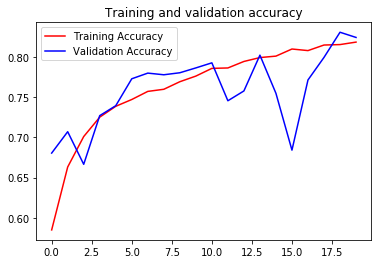

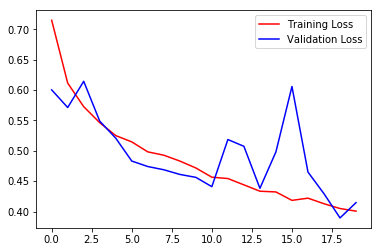

<Figure size 432x288 with 0 Axes>

In [13]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=train_history.history['acc']
val_acc=train_history.history['val_acc']
loss=train_history.history['loss']
val_loss=train_history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend()
plt.figure()

plt.show()

#### It would make sense to run it for more epochs as the accuracy is still trending up.